In [1]:
import numpy as np
from importlib import reload

from astropy import units as u
from astropy import constants as cnst
from astropy import modeling

from astropy.visualization import hist as ahist

import data_loaders

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams, style
rcParams['axes.prop_cycle'] = style.library['seaborn-deep']['axes.prop_cycle']

# Load ELVIS halos 

In [3]:
elvii_pairs = data_loaders.load_elvii_z0()

Loading /Users/erik/projects/lsst_experiments/elvis_data/PairedCatalogs/Hall&Oates.txt
Loading /Users/erik/projects/lsst_experiments/elvis_data/PairedCatalogs/Hamilton&Burr.txt
Loading /Users/erik/projects/lsst_experiments/elvis_data/PairedCatalogs/Kek&Kauket.txt
Loading /Users/erik/projects/lsst_experiments/elvis_data/PairedCatalogs/Lincoln&Douglas.txt
Loading /Users/erik/projects/lsst_experiments/elvis_data/PairedCatalogs/Orion&Taurus.txt
Loading /Users/erik/projects/lsst_experiments/elvis_data/PairedCatalogs/Romulus&Remus.txt
Loading /Users/erik/projects/lsst_experiments/elvis_data/PairedCatalogs/Scylla&Charybdis.txt
Loading /Users/erik/projects/lsst_experiments/elvis_data/PairedCatalogs/Serena&Venus.txt
Loading /Users/erik/projects/lsst_experiments/elvis_data/PairedCatalogs/Siegfried&Roy.txt
Loading /Users/erik/projects/lsst_experiments/elvis_data/PairedCatalogs/Sonny&Cher.txt
Loading /Users/erik/projects/lsst_experiments/elvis_data/PairedCatalogs/Thelma&Louise.txt
Loading /Users/e

# Now try the Watkins+10 estimator

In [7]:
def watkins10_mass_estimator(r, vs, alpha, beta, gamma, vlos=True):
    rout = np.max(r)
    C = (alpha + gamma - 2*beta) / (3-2*beta) * rout**(1-alpha)
    if vlos:
        C *= 3
    return (C/cnst.G * np.mean(vs**2  * r**alpha)).to(u.solMass)

## First populate the catalogs with velocity info 

In [8]:
# this is for the location, but *not* the velocity.  So v_gsr-ish
earth_location = [8.5, 0, 0]*u.kpc 

for nms, cat in elvii_pairs.items():
    for i in (0, 1):
        dx = cat['X'] - cat['X'][i] - earth_location[0]
        dy = cat['Y'] - cat['Y'][i] - earth_location[1]
        dz = cat['Z'] - cat['Z'][i] - earth_location[2]
        earth_dist = (dx**2 + dy**2 + dz**2)**0.5
        xhat, yhat, zhat  = dx/earth_dist, dy/earth_dist, dz/earth_dist
        dvx = cat['Vx'] - cat['Vx'][i]
        dvy = cat['Vy'] - cat['Vy'][i]
        dvz = cat['Vz'] - cat['Vz'][i]
        
        vtot = (dvx**2 + dvy**2 + dvz**2)**0.5
        vlos = xhat*dvx + yhat*dvy + zhat*dvz
        vtan = (vtot**2 - vlos**2)**0.5
        
        for var in 'vtot,vlos,vtan,earth_dist'.split(','):
            cat['host{}_{}'.format(i, var)] = locals()[var]

## Now apply the estimator to the ELVII host for increasing numbers of dwarfs (using some not terribly bad assumed parameters)

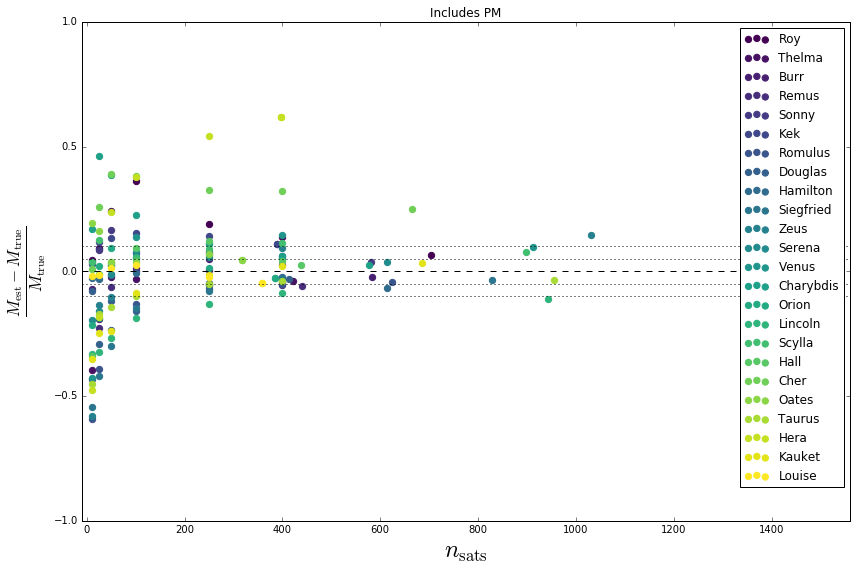

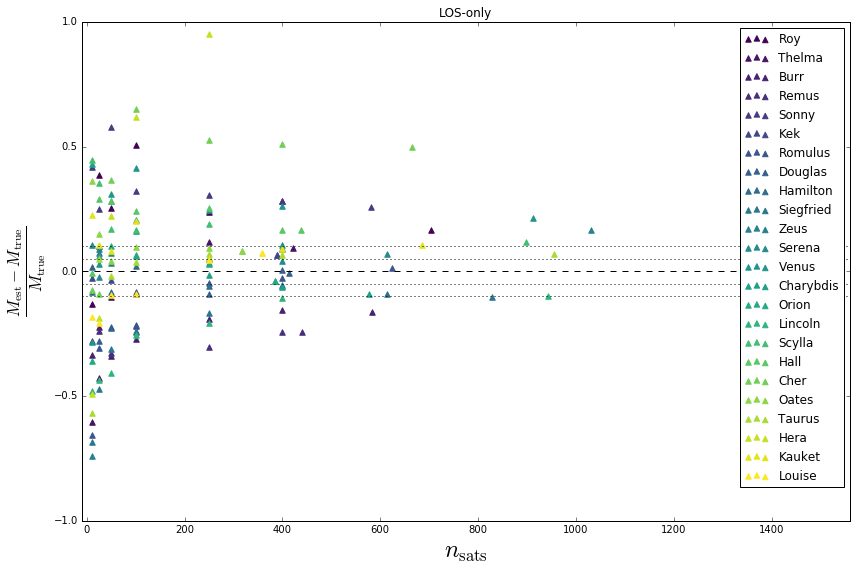

In [9]:
M_toplot = {}

est_params = dict(alpha=0.55, beta=0., gamma=2.5)

for nms, halocat in elvii_pairs.items():
    for i in (0, 1):
        nm = nms.split('&')[i]
        M_host = halocat[i]['Mvir']
        
        #satcat0 = halocat[halocat['sat_of_'+str(i)]]
        # use Rvir measure instead because the mass estimator is radial
        satcat0_msk = halocat['host{}_dist'.format(i)] <= halocat['Rvir'][i]
        satcat0 = halocat[satcat0_msk]
        
        ns = []
        M_vlos_errs = []
        M_vtot_errs = []
        for nlim in nlims:
            satcat = satcat0
            if nlim is not None:
                sorti = np.argsort(satcat['Mstar_preferred'])
                satcat = satcat[sorti[:nlim]]
                
            M_vlos = watkins10_mass_estimator(satcat['host{}_dist'.format(i)], 
                                              satcat['host{}_vlos'.format(i)], 
                                              vlos=True, **est_params)
            M_vtot = watkins10_mass_estimator(satcat['host{}_dist'.format(i)], 
                                              satcat['host{}_vtot'.format(i)], 
                                              vlos=False, **est_params)

            M_vlos_errs.append((M_vlos - M_host) / M_host)
            M_vtot_errs.append((M_vtot - M_host) / M_host)
            ns.append(len(satcat))
        M_toplot[nm] = (ns, M_vlos_errs, M_vtot_errs)

for inclpm in (True, False):
    plt.figure(figsize=(12, 8))
    colors = iter(plt.cm.viridis(np.linspace(0,1,len(M_toplot))))
    for nm, (ns, M_vlos_errs, M_vtot_errs) in M_toplot.items():
        c = next(colors)
        if inclpm:
            plt.scatter(ns, M_vtot_errs, label=nm, color=c, s=40, marker='o')
        else:
            plt.scatter(ns, M_vlos_errs, label=nm, color=c, s=30, marker='^')
            
    plt.axhline(0, color='k', ls='--')
    for l in [.05, .1, -.05, -.1]:
        plt.axhline(l, color='k', ls=':')
    
    plt.xlim(-10, plt.xlim()[1]*1.3)
    plt.ylim(-1, 1)
    
    plt.legend(loc=0)
    plt.xlabel(r'$n_{\rm sats}$', fontsize=24)
    plt.ylabel(r'$\frac{M_{\rm est} - M_{\rm true}}{M_{\rm true}}$', fontsize=24)
    
    if inclpm:
        plt.title('Includes PM')
    else:
        plt.title('LOS-only')
        
    plt.tight_layout()

# Estmate $\gamma$ (tracer density power law index) in ELVIS

In [4]:
def gamma_estimate(rs):
    rs = np.sort(rs)
    
    plmod = modeling.models.PowerLaw1D(x_0=rs[len(rs)//2], amplitude=len(rs)//2)
    plmod.x_0.fixed = True
    
    newplmod = modeling.fitting.LevMarLSQFitter()(plmod, rs, np.arange(len(rs)))
    
    return 3 + newplmod.alpha.value, newplmod

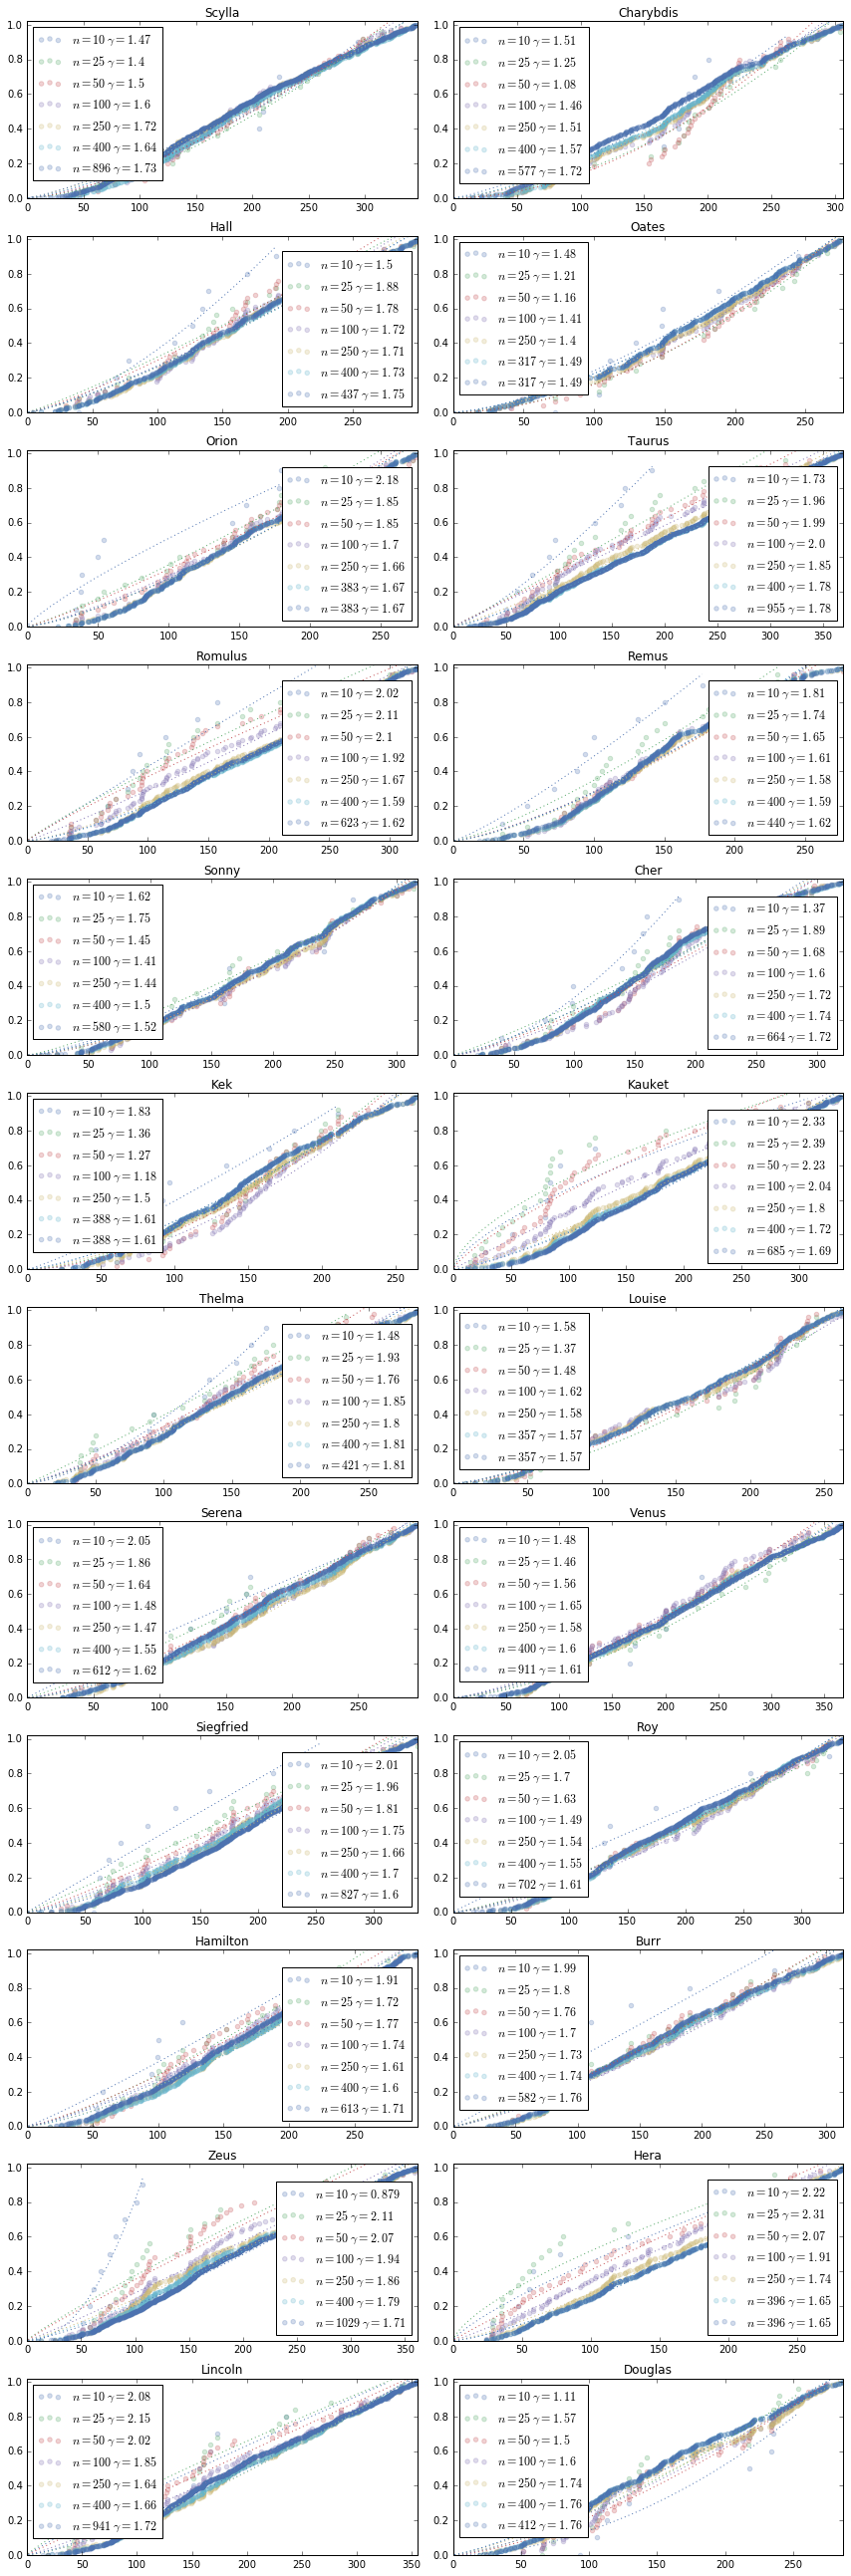

In [5]:
nlims = [10, 25, 50, 100, 250, 400, None] # ordered by M

gamma_estimates = {}

plt.figure(figsize=(12,36))
plnum = 0
for nms, halocat in elvii_pairs.items():
    for i in (0, 1):
        nm = nms.split('&')[i]
        satcat0 = halocat[halocat['sat_of_'+str(i)]]
        
        plnum += 1
        plt.subplot(12, 2, plnum)
        maxr = 0
        maxn = 0
        for nlim in nlims:
            satcat = satcat0
            if nlim is not None:
                sorti = np.argsort(satcat['Mstar_preferred'])
                satcat = satcat[sorti[:nlim]]
            rs = np.sort(satcat['host{}_dist'.format(i)].to(u.kpc).value)*u.kpc

            gamma, newplmod = gamma_estimate(rs)
            gamma_estimates.setdefault(len(satcat), {})[nm] = gamma

            xs = np.linspace(1, rs[-1].value, 100)
            
            N = 1/len(satcat)
            pl = plt.plot(xs, newplmod(xs)*N, zorder=2, ls=':')
            plt.scatter(rs, np.arange(len(rs))*N, color=pl[0].get_color(),
                        label='$n={} \; \gamma={:.3}$'.format(len(satcat), gamma), 
                        alpha=.25, zorder=1)
            
            plt.legend(loc=0)
            maxr = max(maxr, rs[-1].value)
            maxn = max(maxn, len(satcat))
            
        plt.title(nm)
        plt.xlim(0, maxr)
        plt.ylim(0, 1.02)
plt.tight_layout()

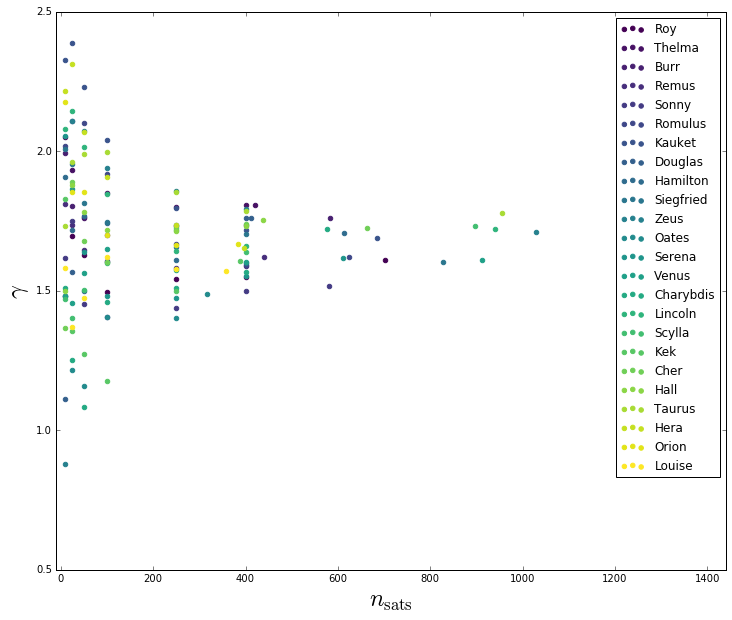

In [6]:
nm_to_plot = {}
for n, d in gamma_estimates.items():
    for nm, gamma in d.items():
        nm_to_plot.setdefault(nm, []).append((n, gamma))
        
plt.figure(figsize=(12, 10))
colors = iter(plt.cm.viridis(np.linspace(0,1,len(nm_to_plot))))
for nm, tp in nm_to_plot.items():
    plt.scatter(*np.array(tp).T, label=nm, color=next(colors))

plt.legend(loc=0)
plt.xlim(-10, plt.xlim()[1]*1.2)
plt.xlabel('$n_{\\rm sats}$', fontsize=24)
plt.ylabel('$\\gamma$', fontsize=24)

# Additional experiments 

## What if we set gamma based on the cumulative distribution estimator and use *that* gamma for the calculation with the Watkins estimator? 

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: divide by zero encountered in power
  return amplitude * xx ** (-alpha)
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:62: RuntimeWarning: divide by zero encountered in reciprocal
  d_amplitude = xx ** (-alpha)
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:64: RuntimeWarning: divide by zero encountered in log
  d_alpha = -amplitude * d_amplitude * np.log(xx)


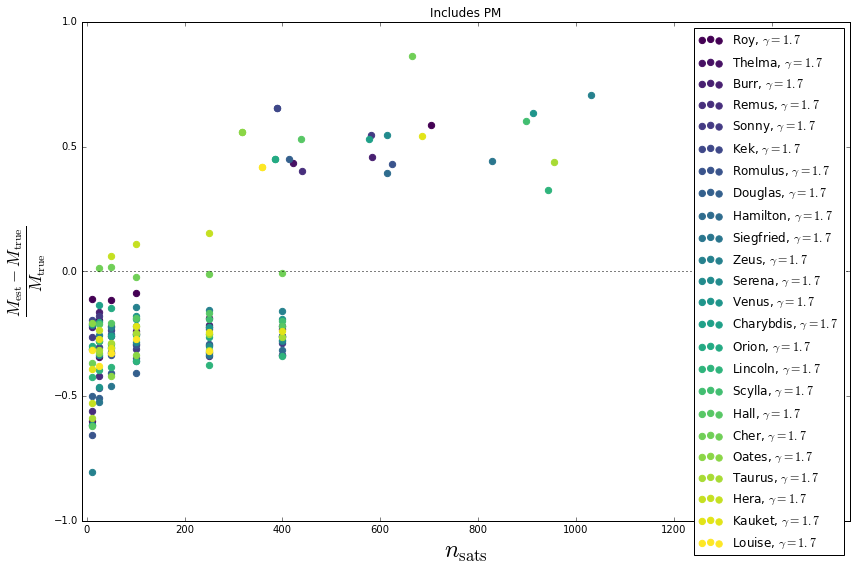

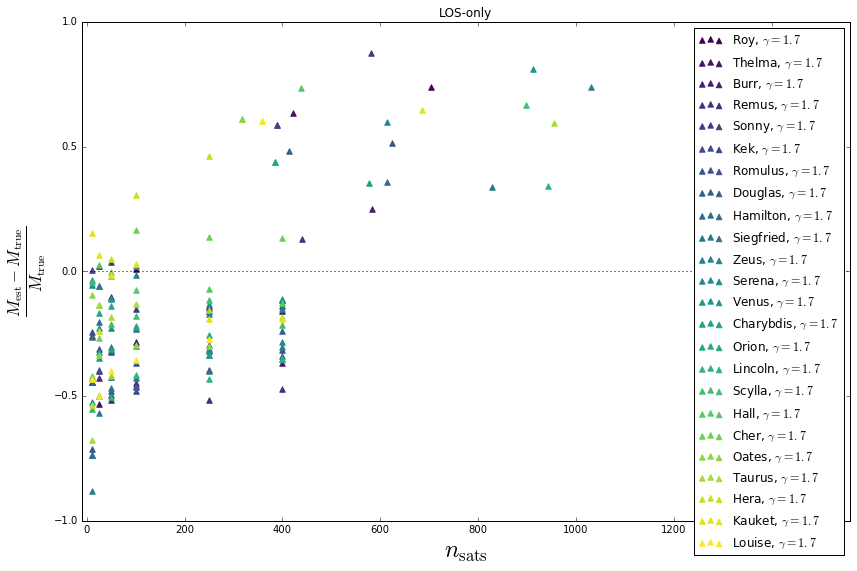

In [10]:
M_toplot = {}

est_params = dict(alpha=0.55, beta=0., gamma=2.5)

for nms, halocat in elvii_pairs.items():
    for i in (0, 1):
        nm = nms.split('&')[i]
        M_host = halocat[i]['Mvir']
        
        #satcat0 = halocat[halocat['sat_of_'+str(i)]]
        # use Rvir measure instead because the mass estimator is radial
        satcat0_msk = halocat['host{}_dist'.format(i)] <= halocat['Rvir'][i]
        satcat0 = halocat[satcat0_msk]
        
        ns = []
        M_vlos_errs = []
        M_vtot_errs = []
        for nlim in nlims:
            satcat = satcat0
            if nlim is not None:
                sorti = np.argsort(satcat['Mstar_preferred'])
                satcat = satcat[sorti[:nlim]]
                
            est_params['gamma'] = gamma_estimate(satcat['host{}_dist'.format(i)])[0]
                
            M_vlos = watkins10_mass_estimator(satcat['host{}_dist'.format(i)], 
                                              satcat['host{}_vlos'.format(i)], 
                                              vlos=True, **est_params)
            M_vtot = watkins10_mass_estimator(satcat['host{}_dist'.format(i)], 
                                              satcat['host{}_vtot'.format(i)], 
                                              vlos=False, **est_params)

            M_vlos_errs.append((M_vlos - M_host) / M_host)
            M_vtot_errs.append((M_vtot - M_host) / M_host)
            ns.append(len(satcat))
        M_toplot[nm] = (ns, M_vlos_errs, M_vtot_errs)

for inclpm in (True, False):
    plt.figure(figsize=(12, 8))
    colors = iter(plt.cm.viridis(np.linspace(0,1,len(M_toplot))))
    for nm, (ns, M_vlos_errs, M_vtot_errs) in M_toplot.items():
        c = next(colors)
        if inclpm:
            plt.scatter(ns, M_vtot_errs, 
                        label='{}, $\\gamma={:.2}$'.format(nm, gamma), 
                        color=c, s=40, marker='o')
        else:
            plt.scatter(ns, M_vlos_errs, 
                        label='{}, $\\gamma={:.2}$'.format(nm, gamma), 
                        color=c, s=30, marker='^')
            
    plt.axhline(0, color='k', ls=':')
    
    plt.xlim(-10, plt.xlim()[1]*1.3)
    plt.ylim(-1, 1)
    
    plt.legend(loc=0)
    plt.xlabel(r'$n_{\rm sats}$', fontsize=24)
    plt.ylabel(r'$\frac{M_{\rm est} - M_{\rm true}}{M_{\rm true}}$', fontsize=24)
    
    if inclpm:
        plt.title('Includes PM')
    else:
        plt.title('LOS-only')
        
    plt.tight_layout()

Clearly this is an insufficient $\gamma$-estimator...

## Varying beta? 

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


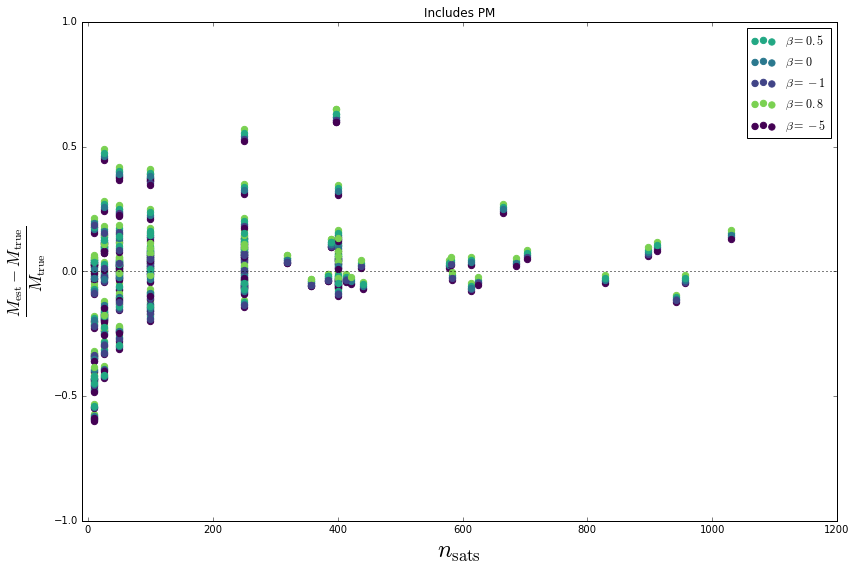

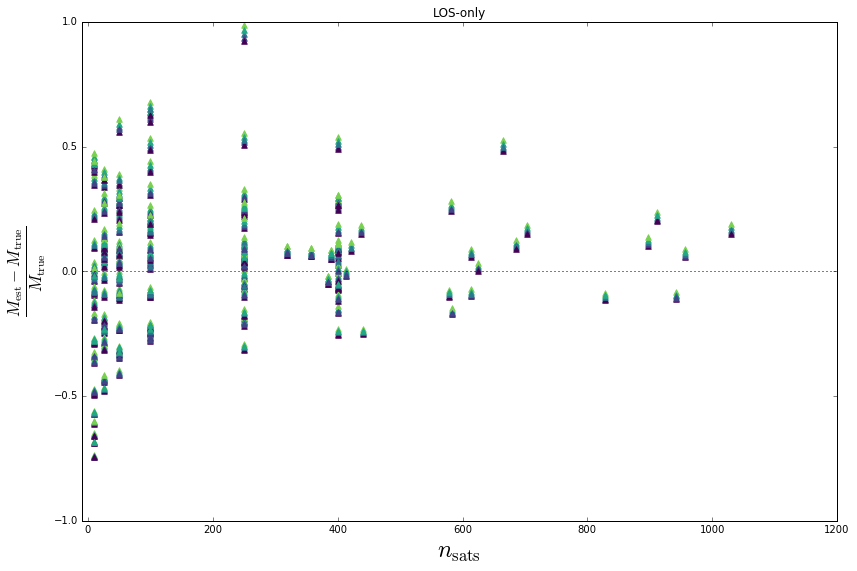

In [11]:
M_toplot = {}

est_params = dict(alpha=0.55, beta=0., gamma=2.5)

betas = [-5, -1, 0, 0.5, 0.8]
for beta in betas:
    est_params['beta'] = beta
    for nms, halocat in elvii_pairs.items():
        for i in (0, 1):
            nm = nms.split('&')[i]
            M_host = halocat[i]['Mvir']

            #satcat0 = halocat[halocat['sat_of_'+str(i)]]
            # use Rvir measure instead because the mass estimator is radial
            satcat0_msk = halocat['host{}_dist'.format(i)] <= halocat['Rvir'][i]
            satcat0 = halocat[satcat0_msk]

            ns = []
            M_vlos_errs = []
            M_vtot_errs = []
            for nlim in nlims:
                satcat = satcat0
                if nlim is not None:
                    sorti = np.argsort(satcat['Mstar_preferred'])
                    satcat = satcat[sorti[:nlim]]

                M_vlos = watkins10_mass_estimator(satcat['host{}_dist'.format(i)], 
                                                  satcat['host{}_vlos'.format(i)], 
                                                  vlos=True, **est_params)
                M_vtot = watkins10_mass_estimator(satcat['host{}_dist'.format(i)], 
                                                  satcat['host{}_vtot'.format(i)], 
                                                  vlos=False, **est_params)

                M_vlos_errs.append((M_vlos - M_host) / M_host)
                M_vtot_errs.append((M_vtot - M_host) / M_host)
                ns.append(len(satcat))
            M_toplot[(nm, est_params['beta'])] = (ns, M_vlos_errs, M_vtot_errs)

colors = {betas[i]: plt.cm.viridis(i/len(betas)) for i in range(len(betas))}
labeled_betas = []
for inclpm in (True, False):
    plt.figure(figsize=(12, 8))
    
    for (nm, beta), (ns, M_vlos_errs, M_vtot_errs) in M_toplot.items():
        c = colors[beta]
        
        label = ''
        if beta not in labeled_betas:
            label = r'$\beta={}$'.format(beta)
            labeled_betas.append(beta)
            
        if inclpm:
            plt.scatter(ns, M_vtot_errs, label=label, color=c, s=40, marker='o')
        else:
            plt.scatter(ns, M_vlos_errs, label=label, color=c, s=30, marker='^')
            
    plt.axhline(0, color='k', ls=':')
    
    plt.xlim(-10, plt.xlim()[1])
    plt.ylim(-1, 1)
    
    plt.legend(loc=0)
    plt.xlabel(r'$n_{\rm sats}$', fontsize=24)
    plt.ylabel(r'$\frac{M_{\rm est} - M_{\rm true}}{M_{\rm true}}$', fontsize=24)
    
    if inclpm:
        plt.title('Includes PM')
    else:
        plt.title('LOS-only')
        
    plt.tight_layout()